# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

import os
import sys
import math
import gc

from copy import deepcopy

from itertools import chain
from collections import OrderedDict

import numpy as np
import pandas as pd
from scipy.linalg import orth

import seaborn as sns

from scipy.spatial.distance import pdist, squareform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import torch
import torch.nn as nn 
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST

from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

use_cuda = False
device = None
os.environ["CUDA_VISIBLE_DEVICES"]="5"
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    use_cuda = True

# Ignore cuda
# use_cuda = False
# device = None

# Set DoubleTensor as a base type for computations
t_type = torch.float64

In [2]:
import warnings
import functools

def deprecated(func):
    """This is a decorator which can be used to mark functions
    as deprecated. It will result in a warning being emitted
    when the function is used."""
    @functools.wraps(func)
    def new_func(*args, **kwargs):
        warnings.simplefilter('always', DeprecationWarning)  # turn off filter
        warnings.warn("Call to deprecated function {}.".format(func.__name__),
                      category=DeprecationWarning,
                      stacklevel=2)
        warnings.simplefilter('default', DeprecationWarning)  # reset filter
        return func(*args, **kwargs)
    return new_func

In [3]:
%load_ext line_profiler

# Support classes and functions

In [4]:
def print_plots(data, axis, labels, file_name=None):
    N_plots = len(data)
    plt.figure(figsize=(30, (N_plots // 3 + 1) * 10))

    for idx in range(len(data)):
        plt.subplot(N_plots // 3 + 1, 3, idx + 1)
        for jdx in range(len(data[idx])):
            plt.plot(data[idx][jdx], label=labels[idx][jdx])
        plt.xlabel(axis[idx][0], fontsize=16)
        plt.ylabel(axis[idx][1], fontsize=16)
        plt.legend(loc=0, fontsize=16)
    if file_name is not None:
        plt.savefig(file_name)

In [5]:
def plot_projections(dm=None, use_real=True, kernel='tri', pdf=None, N_plots_max=10):
    """
        Plot marginal kernel density estimation
    Args:
        dm (DistributionMover): class containing particles which define distribution
        use_real (bool): If set to True then apply transformation dm.lt.transform before creating plot
        kernel (str): Kernel type for kernel density estimation
        pdf (array_like, None): Samples from target distribution
        N_plots_max (int): Maximum number of plots
    """
    N_plots = None
    scale_factor = None
    
    if use_real:
        if not dm.use_latent:
            return
        N_plots = dm.lt.A.shape[0]
    else:
        N_plots = dm.particles.shape[0]
    if N_plots > 6:
        scale_factor = 15
    else:
        scale_factor = 5
        
    N_plots = min(N_plots, N_plots_max)
        
    plt.figure(figsize=(3 * scale_factor, (N_plots // 3 + 1) * scale_factor))
    
    for idx in range(N_plots):
        slice_dim = idx
        
        plt.subplot(N_plots // 3 + 1, 3, idx + 1)
        
        particles = None
        if use_real:
            particles = dm.lt.transform(dm.particles, n_particles_second=True).t()[:, slice_dim]
        else:
            particles = dm.particles.t()[:, slice_dim]
        
        if pdf is not None:
            plt.plot(np.linspace(-10, 10, len(pdf), dtype=np.float64), pdf)
        plt.plot(particles.data.cpu().numpy(), torch.zeros_like(particles).data.cpu().numpy(), 'ro')
        sns.kdeplot(particles.data.cpu().numpy(), 
                    kernel=kernel, color='darkblue', linewidth=4)
    plt.show()

In [6]:
def plot_condition_distribution(dm, n_samples):
    """
    Args:
        dm (DistributionMover): object contains unconditioned density, linear manifold and particles
        n_samples (int): number of samples
    Return:
        (points, weight)
    """
    if not dm.use_latent:
        return
    
    points = torch.zeros([dm.n_hidden_dims, n_samples], dtype=t_type, device=device).uniform_(-10, 10)
    weight = dm.real_target_density(dm.lt.transform(points, n_particles_second=True))
    points = points.view(-1)
    
    plt.hist(points.data.cpu().numpy(), weights=weight.data.cpu().numpy(), density=True, bins=100, alpha=0.5, label='True conditional density')
    plt.plot(dm.particles.data.cpu().numpy(), torch.zeros_like(dm.particles).data.cpu().numpy(), 'ro')
    sns.kdeplot(dm.particles[0, :].data.cpu().numpy(), 
                kernel='tri', color='darkblue', linewidth=4, label='Approximated conditional density')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [7]:
def pairwise_diffs(x, y, n_particles_second=True):
    """
    Args:
        if n_particles_second == True:
            Input: x is a dxN matrix
                   y is an optional dxM matrix
            Output: diffs is a dxNxM matrix where diffs[i,j] is the subtraction between x[:,i] and y[:,j]
            i.e. diffs[i,j] = x[:,i] - y[:,j]

        if n_particles_second == False:
            Input: x is a Nxd matrix
                   y is an optional Mxd matrix
            Output: diffs is a NxMxd matrix where diffs[i,j] is the subtraction between x[i,:] and y[j,:]
            i.e. diffs[i,j] = x[i,:]-y[j,:]
    """
    if n_particles_second:
        return x[:,:,np.newaxis] - y[:,np.newaxis,:]        
    return x[:,np.newaxis,:] - y[np.newaxis,:,:]

In [8]:
def pairwise_dists(diffs=None, n_particles_second=True):
    """
    Args:
        if n_particles_second == True:
            Input: diffs is a dxNxM matrix where diffs[i,j] = x[:,i] - y[:,j]
            Output: dist is a NxM matrix where dist[i,j] is the square norm of diffs[i,j]
            i.e. dist[i,j] = ||x[:,i] - y[:,j]||

        if n_particles_second == False:
            Input: diffs is a NxMxd matrix where diffs[i,j] = x[i,:] - y[j, :]
            Output: dist is a NxM matrix where dist[i,j] is the square norm of diffs[i,j]
            i.e. dist[i,j] = ||x[i,:]-y[j,:]||
    """
    if n_particles_second:
        return torch.norm(diffs, dim=0)
    return torch.norm(diffs, dim=2)

In [9]:
class normal_density():
    """
        Multinomial normal density for independent random variables. 
    """
    def __init__(self, n=1, mu=0., std=1., n_particles_second=True):
        """
        Args:
            n (int): number of dimensions of multinomial normal distribution
                Default: 1
            mu (float, array_like): mean of distribution
                Default: 0.
                if mu is float - use same mean across all dimensions
                if mu is 1D array_like - use different mean for each dimension but same for each particles dimension
                if mu is 2D array_like - use different mean for each dimension
            std (float, array_like): std of distribution
                Default: 1.
                if std is float - use same std across all dimensions
                if std is 1D array_like - use different std for each dimension but same for each particles dimension
                if std is 2D array_like - use different std for each dimension
            n_particles_second (bool): specify type of input
                Default: True
                if n_particles_second == True - input must has shape [n, n_particles]
                if n_particles_second == False - input must has shape [n_particles, n]
                Therefore the same mu and std are applied along particles axis
                Input will be reduced along all axis exclude particle axis
        """
        
        self.n = torch.tensor(n, dtype=t_type, device=device)
        self.n_particles_second = n_particles_second
        
        self.mu = mu
        self.std = std
        
        if isinstance(self.mu, float):
            self.mu = torch.tensor(self.mu, dtype=t_type, device=device).expand(n)      
        if len(self.mu.shape) == 1:
            if self.mu.shape[0] == 1:
                self.mu = self.mu.view(1).expand(n)
            if self.n_particles_second:
                self.mu = torch.tensor(self.mu, dtype=t_type, device=device).view(n, 1)
            else:
                self.mu = torch.tensor(self.mu, dtype=t_type, device=device).view(1, n)
        elif len(self.mu.shape) == 2:
            self.mu = torch.tensor(self.mu, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        if isinstance(self.std, float):
            self.std = torch.tensor(self.std, dtype=t_type, device=device).expand(n)        
        if len(self.std.shape) == 1:
            if len(self.std) == 1:
                self.std = self.std.view(1).expand(n)
            if self.n_particles_second:
                self.std = torch.tensor(self.std, dtype=t_type, device=device).view(n, 1)
            else:
                self.std = torch.tensor(self.std, dtype=t_type, device=device).view(1, n)
        elif len(self.std.shape) == 2:
            self.std = torch.tensor(self.std, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        self.zero = torch.tensor(0., dtype=t_type, device=device)
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        self.pi = torch.tensor(math.pi, dtype=t_type, device=device)
        
        ### specify axis to reduce
        ### if n_particles_second == True - n_axis == 0
        ### if n_particles_second == False - n_axis == 1
        self.n_axis = 1 - int(self.n_particles_second)
        
    def __call__(self, x, n_axis=None):        
        """
            Evaluate density in given point
        Args:
            x (torch.tensor): tensor which defines point where density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.pow(self.two * self.pi, -self.n / self.two) / 
                torch.prod(self.std, dim=n_axis) * 
                torch.exp(-self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std, self.two), dim=n_axis)))
    
    def unnormed_density(self, x, n_axis=None):      
        """
            Evaluate unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return torch.exp(-self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std , self.two), dim=n_axis))
    
    def log_density(self, x, n_axis=None):  
        """
            Evaluate log density in given point
        Args:
            x (torch.tensor): tensor which defines point where log density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (-self.n / self.two * torch.log(self.two * self.pi) + 
                torch.sum(torch.log(self.std), dim=n_axis) -
                self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std, self.two), dim=n_axis))
                
    def log_unnormed_density(self, x, n_axis=None):
        """
            Evaluate log unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where log unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return -self.one / self.two * torch.sum(torch.pow((x - self.mu) / self.std, self.two), dim=n_axis)
    
    def get_sample(self):
        """
            Sample from normal distribution
        """
        sample = torch.normal(self.mu, self.std)
        if self.n_particles_second:
            return sample.view(-1, 1)
        else:
            return sample.view(1, -1)

In [10]:
class gamma_density():
    """
        Multinomial gamma density for independent random variables. 
    """
    def __init__(self, n=1, alpha=1, betta=1, n_particles_second=True):
        """
        Args:
            n (int): number of dimensions of multinomial normal distribution
                Default: 1
            alpha (float, array_like): shape of distribution
                Default: 1.
                if alpha is float - use same shape across all dimensions
                if alpha is 1D array_like - use different shape for each dimension but same for each particles dimension
                if alpha is 2D array_like - use different shape for each dimension
            betta (float, array_like): rate of distribution
                Default: 1.
                if betta is float - use same rate across all dimensions
                if betta is 1D array_like - use different rate for each dimension but same for each particles dimension
                if betta is 2D array_like - use different rate for each dimension
            n_particles_second (bool): specify type of input
                Default: True
                if n_particles_second == True - input must has shape [n, n_particles]
                if n_particles_second == False - input must has shape [n_particles, n]
                Therefore the same mu and std are applied along particles axis  
        """
        
        self.n = torch.tensor(n, dtype=t_type, device=device)
        self.n_particles_second = n_particles_second
        
        self.alpha = alpha
        self.betta = betta
        
        if isinstance(self.alpha, float):
            self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device).expand(n)      
        if len(self.alpha.shape) == 1:
            if self.alpha.shape[0] == 1:
                self.alpha = self.alpha.view(1).expand(n)
            if self.n_particles_second:
                self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device).view(n, 1)
            else:
                self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device).view(1, n)
        elif len(self.alpha.shape) == 2:
            self.alpha = torch.tensor(self.alpha, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        if isinstance(self.betta, float):
            self.betta = torch.tensor(self.betta, dtype=t_type, device=device).expand(n)        
        if len(self.betta.shape) == 1:
            if len(self.betta) == 1:
                self.betta = self.betta.view(1).expand(n)
            if self.n_particles_second:
                self.betta = torch.tensor(self.betta, dtype=t_type, device=device).view(n, 1)
            else:
                self.betta = torch.tensor(self.betta, dtype=t_type, device=device).view(1, n)
        elif len(self.std.shape) == 2:
            self.betta = torch.tensor(self.betta, dtype=t_type, device=device)
        else:
            raise RuntimeError
            
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        
        ### specify axis to reduce
        ### if n_particles_second == True - n_axis == 0
        ### if n_particles_second == False - n_axis == 1
        self.n_axis = 1 - int(self.n_particles_second)
        
        ### log Г(alpha)
        self.lgamma = torch.lgamma(self.alpha)
        ### Г(alpha)
        self.gamma = torch.exp(self.lgamma)

    def __call__(self, x, n_axis=None):
        """
            Evaluate density in given point
        Args:
            x (torch.tensor): tensor which defines point where density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.prod(torch.pow(self.betta, self.alpha) / self.gamma * torch.pow(x, self.alpha - self.one), dim=n_axis) * 
                torch.exp(-torch.sum(self.betta * x, dim=n_axis)))
    
    def unnormed_density(self, x, n_axis=None):
        """
            Evaluate unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.prod(torch.pow(x, self.alpha - self.one), dim=n_axis) * 
                torch.exp(-torch.sum(self.betta * x, dim=n_axis)))
    
    def log_density(self, x, n_axis=None):
        """
            Evaluate log density in given point
        Args:
            x (torch.tensor): tensor which defines point where log density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum(self.alpha * torch.log(self.betta) - self.lgamma + (self.alpha - self.one) * torch.log(x), dim=n_axis) -
                torch.sum(self.betta * x, dim=n_axis))
                
    def log_unnormed_density(self, x, n_axis=None):
        """
            Evaluate log unnormed density in given point
        Args:
            x (torch.tensor): tensor which defines point where log unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum((self.alpha - self.one) * torch.log(x), dim=n_axis) -
                torch.sum(self.betta * x, dim=n_axis))
                
    def log_density_log_x(self, log_x, n_axis=None):
        """
            Evaluate log density in point log(x)
        Args:
            x (torch.tensor): tensor which defines point where log density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum(self.alpha * torch.log(self.betta) - self.lgamma + (self.alpha - self.one) * log_x, dim=n_axis) -
                torch.sum(self.betta * torch.exp(log_x), dim=n_axis))
                
    def log_unnormed_density_log_x(self, log_x, n_axis=None):
        """
            Evaluate log unnormed density in point log(x)
        Args:
            x (torch.tensor): tensor which defines point where log unnormed density is evaluated
            n_axis (int): specify axis to reduce
                Default: 
                    if n_particles_second == True - n_axis == 0
                    if n_particles_second == False - n_axis == 1
        """
        n_axis = self.n_axis if n_axis is None else n_axis
        return (torch.sum((self.alpha - self.one) * log_x, dim=n_axis) -
                torch.sum(self.betta * torch.exp(log_x), dim=n_axis))

In [11]:
class SteinLinear(nn.Module):
    """
        Custom full connected layer for Stein Gradient Neural Networks
        Transformation: y = xA + b
        Parameters prior: 
            1 - p(w, a) = p(w|a)p(a) = П p(w_i|a_i)p(a_i)
                p(w_i|a_i) = N(w_i|0, a_i^(-1)); p(a_i) = G(1e-4, 1e-4)
                          
            2 - p(w) = П p(w_i)
                p(w_i) = N(w_i|0, alpha^(-1))
    """
    def __init__(self, in_features, out_features, n_particles=1, use_bias=True, use_var_prior=True, alpha=1e-2):
        super(SteinLinear, self).__init__()
        """
        Args:
            in_features (int): size of each input sample
            out_features (int): size of each output sample
            n_particles (int): number of particles
            use_bias (bool): If set to False, the layer will not learn an additive bias.
                Default: True
            use_var_prior (bool): If set to True, use Gamma prior distribution of weight variance
                Default: True
            alpha (float): If use_var_prior == False - defines weight variance
                Default: 1e-2
        """
        
        self.in_features = in_features
        self.out_features = out_features
        self.n_particles = n_particles
        self.use_bias = use_bias
        self.use_var_prior = use_var_prior

        ### if alpha is None use GLOROT prior
        if alpha is None:
            self.alpha_weight = (self.in_features + self.out_features) / 2.
            self.alpha_bias = (self.out_features) / 2.
        else:
            self.alpha_weight = alpha
            self.alpha_bias = alpha
    
        
        self.weight = torch.nn.Parameter(torch.zeros([in_features, out_features, n_particles], dtype=t_type, device=device))
        if self.use_var_prior:
            self.log_weight_alpha = torch.nn.Parameter(torch.zeros([in_features * out_features, n_particles], dtype=t_type, device=device))
        else:
            self.log_weight_alpha = torch.tensor([math.log(self.alpha_weight)], dtype=t_type, device=device, requires_grad=False)
        
        if self.use_bias:
            self.bias = torch.nn.Parameter(torch.zeros([1, out_features, n_particles], dtype=t_type, device=device))
            if self.use_var_prior:
                self.log_bias_alpha = torch.nn.Parameter(torch.zeros([out_features, n_particles], dtype=t_type, device=device))
            else:
                self.log_bias_alpha = torch.tensor([math.log(self.alpha_bias)], dtype=t_type, device=device, requires_grad=False)
        
        if self.use_var_prior:
            ### define prior on alpha p(a) = G(1e-4, 1e-4)
            self.weight_alpha_log_prior = lambda x: (gamma_density(n=self.log_weight_alpha.shape[0],
                                                                   alpha=1e-4,
                                                                   betta=1e-4,
                                                                   n_particles_second=True
                                                                  ).log_unnormed_density_log_x(x))
            if self.use_bias:
                self.bias_alpha_log_prior = lambda x: (gamma_density(n=self.log_bias_alpha.shape[0],
                                                                     alpha=1e-4,
                                                                     betta=1e-4,
                                                                     n_particles_second=True
                                                                    ).log_unnormed_density_log_x(x))
        
        self.one = torch.tensor(1., dtype=t_type, device=device)
        
        self.reset_parameters()
        
    ### useless function - all initialization defined in DistributionMover class
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.out_features)
        self.weight.data.uniform_(-stdv, stdv)
        self.log_weight_alpha.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)
            self.log_bias_alpha.data.uniform_(-stdv, stdv)
            
    def forward(self, X):
        """
            Apply transformation: X_out[i, :, :] = X_in[i, :, :] * W + b[i]
        Args:
            X (torch.tensor): tensor 
        Shape:
            Input: [n_particles, batch_size, in_features]
            Output: [n_particles, batch_size, out_features]
        """
        ### NEED SOME OPTIMIZATION TO OMMIT .permute
        if self.use_bias:
            return torch.bmm(X, self.weight.permute(2, 0, 1)) + self.bias.permute(2, 0, 1)
        return torch.bmm(X, self.weight.permute(2, 0, 1))
    
    def numel(self, trainable=True):
        """
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        """
        if trainable:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())
        
    def calc_log_prior(self):
        """
            Evaluate log prior of trainable parameters
        log p(w,a) = log p(w|a) + log p(a)
        """
        ### define prior on weight p(w|a) = N(0, 1 / alpha)
        weight_log_prior = lambda x: (normal_density(n=self.weight.numel() // self.n_particles,
                                                     mu=0.,
                                                     std=self.one / torch.exp(self.log_weight_alpha),
                                                     n_particles_second=True
                                                    ).log_unnormed_density(x))

        bias_log_prior = lambda x: (normal_density(self.bias.numel() // self.n_particles,
                                                   mu=0.,
                                                   std=self.one / torch.exp(self.log_bias_alpha),
                                                   n_particles_second=True
                                                  ).log_unnormed_density(x))
        
        if self.use_bias:
            if self.use_var_prior:
                return (weight_log_prior(self.weight.view(-1, self.n_particles)) + self.weight_alpha_log_prior(self.log_weight_alpha) +
                        bias_log_prior(self.bias.view(-1, self.n_particles)) + self.bias_alpha_log_prior(self.log_bias_alpha))   
            return (weight_log_prior(self.weight.view(-1, self.n_particles)) +
                    bias_log_prior(self.bias.view(-1, self.n_particles)))     
        
        if self.use_var_prior:
            return weight_log_prior(self.weight.view(-1, self.n_particles)) + self.weight_alpha_log_prior(self.log_weight_alpha)
        return weight_log_prior(self.weight.view(-1, self.n_particles))

In [12]:
class LinearTransform():
    """
        Class for various linear transformations
    """
    def __init__(self, n_dims, n_hidden_dims, use_identity=False, normalize=False, A=None, theta_0=None):
        """
        Args:
            n_dims (int): dimension of the space
            n_hidden_dims (int): dimension of the latent space
            use_identity (bool): If set to True, use 'eye' matrix for transformations
            normalize (bool): If set to True, columns of the transformation matrix is an orthonormal basis 
            A (2D array_like, None): Initial value for transformation matrix
                If None then matrix will be sampled from uniform distribution and then orthonormate
                Default: None
            theta_0 (1D array_like, None): Initial value for bias
                If None then matrix will be sampled from uniform distribution
                Default: None
        """
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims
        self.use_identity = use_identity
        self.normalize = normalize
        
        if self.use_identity:
            return
        
        self.A = A
        self.theta_0 = theta_0
        
        if self.A is None:
            self.A = torch.zeros([self.n_dims, self.n_hidden_dims], dtype=t_type, device=device)
            self.A.uniform_(-1., 1.)
            if self.normalize:
                ### normalize columns of matrix A
                self.A = torch.tensor(orth(self.A.data.cpu().numpy()), dtype=t_type, device=device)
                    
        if self.theta_0 is None:
            self.theta_0 = torch.zeros([self.n_dims, 1], dtype=t_type, device=device)
            self.theta_0.uniform_(-1.,1.)
        
        ### A^(t)A
        self.AtA = torch.matmul(self.A.t(), self.A)
        ### (A^(t)A)^(-1)
        self.AtA_1 = torch.inverse(self.AtA)
        ### (A^(t)A)^(-1)A^(t)
        self.inverse_base = torch.matmul(self.AtA_1, self.A.t())
        
    def transform(self, theta, n_particles_second=True):
        """
            Transform thetas as follows: 
                theta = Atheta` + theta_0
        """
        if self.use_identity:
            return theta
        if n_particles_second:
            return torch.matmul(self.A, theta) + self.theta_0
        return (torch.matmul(self.A, theta.t()) + self.theta_0).t()
    
    def inverse_transform(self, theta, n_particles_second=True):
        """
            Apply inverse transformation: 
                theta` = (A^(t)A)^(-1)A^(t)(theta - theta_0)
        """
        if self.use_identity:
            return theta
        if n_particles_second:
            return torch.matmul(self.inverse_base, theta - self.theta_0)
        return torch.matmul(self.inverse_base, theta.t() - self.theta_0).t()
    
    def project_inverse(self, theta, n_particles_second=True):
        """
            Project and then apply inverse transform to theta - theta_0:
                theta_s_p_i = T^(-1)P(theta - theta_0)= (A^(t)A)^(-1)A^(t)theta
        """
        if self.use_identity:
            return theta
        ### This optimization severely reduces performance!!!!
        ### use solver trick: theta_s_p_i : A^(t)Atheta_s_p_i = A^(t)theta
        if n_particles_second:
            # return torch.gesv(torch.matmul(self.A.t(), theta), self.AtA)[0]
            return torch.matmul(self.inverse_base, theta)
        # return torch.gesv(torch.matmul(self.A.t(), theta.t()), self.AtA)[0].t()
        return torch.matmul(theta, self.inverse_base.t())
        
    def state_dict(self, destination=None, prefix='', keep_vars=False):
        r"""Returns a dictionary containing a whole state of the module.
        Both parameters and persistent buffers (e.g. running averages) are
        included. Keys are corresponding parameter and buffer names.
        Returns:
            dict:
                a dictionary containing a whole state of the module
        Example::
            >>> module.state_dict().keys()
            ['bias', 'weight']
        """
        if destination is None:
            destination = OrderedDict()
            destination._metadata = OrderedDict()
        destination._metadata[prefix[:-1]] = dict(version=1)
        
        destination[prefix + 'A'] = self.A if keep_vars else self.A.data
        destination[prefix + 'theta_0'] = self.theta_0 if keep_vars else self.theta_0.data
        destination[prefix + 'n_dims'] = self.n_dims
        destination[prefix + 'n_hidden_dims'] = self.n_hidden_dims
        destination[prefix + 'use_identity'] = self.use_identity
        destination[prefix + 'normalize'] = self.normalize
        
        return destination
    
    def load_state_dict(self, state_dict, prefix=''):
        self.A.copy_(state_dict[prefix + 'A'])
        self.theta_0.copy_(state_dict[prefix + 'theta_0'])
        self.__init__(state_dict[prefix + 'n_dims'],
                      state_dict[prefix + 'n_hidden_dims'],
                      state_dict[prefix + 'use_identity'],
                      state_dict[prefix + 'normalize'],
                      self.A, self.theta_0
                     )

In [14]:
class RegressionDistribution(nn.Module):
    """
        Distribution over data for regression task: p(D|w) = N(y_predicted|y, )
    """
    def __init__(self, n_particles, use_var_prior=True, betta=1e-1):
        super(RegressionDistribution, self).__init__()
        """
        Args:
            n_particles (int): number of particles
            use_var_prior (bool): If set to True, use Gamma prior distribution of prediction variance
                Default: True
            betta (float): If use_var_prior == False - defines variance of prediction
                Default: 1e-1
        """
        
        self.n_particles = n_particles
        self.use_var_prior = use_var_prior
        self.betta = betta
        
        ### define betta - variance of data distribution for regression tasks (betta = 1 / std ** 2)
        if self.use_var_prior:
            self.log_betta = torch.nn.Parameter(torch.zeros([1, self.n_particles], dtype=t_type, device=device))
        else:
            self.log_betta = torch.tensor([math.log(self.betta)], dtype=t_type, device=device, requires_grad=False)

        if self.use_var_prior:
            ### define prior on betta p(betta)
            self.betta_log_prior = lambda x: (gamma_density(n=1,
                                                            alpha=1e-4,
                                                            betta=1e-4,
                                                            n_particles_second=True
                                                           ).log_unnormed_density_log_x(x))
        
        ### Support tensors for computations
        self.one = torch.tensor(1., dtype=t_type, device=device)
    
    def calc_log_data(self, X, y, y_predict, train_size):  
        """
            Evaluate log p(theta) 
        Args:
            X (array_like): batch of data
            y (array_like): batch of target values
            y_predict (array_like): batch of predicted values
            train_size (int) - size of training dataset
        Shapes:
            y.shape = [batch_size]
            y_predict.shape = [n_particles, batch_size, 1]
        """
        ### squeeze last axis because regression task is being solved
        y_predict.squeeze_(2)
        
        batch_size = torch.tensor(y.shape[0], dtype=t_type, device=device)
        train_size = torch.tensor(train_size, dtype=t_type, device=device)
        
        ### define distribution over data p(D|w)
        ### n_particles_second == False because y_predict has shape = [n_particles, batch_size]
        log_data_distr = None
        if self.use_var_prior:
            log_data_distr = lambda x: (normal_density(n=X.shape[0],
                                                       mu=y,
                                                       std=self.one / torch.sqrt(torch.exp(self.log_betta.expand(X.shape[0], self.n_particles).t())),
                                                       n_particles_second=False
                                                      ).log_unnormed_density(x))
        else:
            log_data_distr = lambda x: (normal_density(n=X.shape[0],
                                                       mu=y,
                                                       std=self.one / torch.sqrt(torch.exp(self.log_betta)),
                                                       n_particles_second=False
                                                      ).log_unnormed_density(x))
            
        if self.use_var_prior:
            return train_size / batch_size * log_data_distr(y_predict) + self.betta_log_prior(self.log_betta)
        return train_size / batch_size * log_data_distr(y_predict)
    
    def modules(self):
        yield self
    
    def numel(self, trainable=True):
        """
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        """
        if trainable:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())

In [15]:
class ClassificationDistribution(nn.Module):
    def __init__(self, n_particles):
        super(ClassificationDistribution, self).__init__()
        """
        Args:
            n_particles (int): number of particles
        """
        self.n_particles = n_particles 

    def calc_log_data(self, X, y, y_predict, train_size):  
        """
            Evaluate log p(theta) 
        Args:
            X (array_like): batch of data
            y (array_like): batch of target values
            y_predict (array_like): batch of predictions
            train_size (int): size of train dataset
        Shapes: 
            X.shape = [batch_size, in_features]
            y.shape = [batch_size]
            y_predict.shape = [n_particles, batch_size, n_classes]
        """
        batch_size = torch.tensor(X.shape[0], dtype=t_type, device=device)
        train_size = torch.tensor(train_size, dtype=t_type, device=device)
        
        ### define distribution over data p(D|w)
        ### n_particles_second == False because y_predict has shape = [n_particles, batch_size]
        
        probas = nn.LogSoftmax(dim=2)(y_predict)
        probas_selected = torch.gather(input=probas, dim=2, index=y.view(1, -1, 1).expand(probas.shape[0], probas.shape[1], 1)).squeeze(2)
        log_data = torch.sum(probas_selected, dim=1)
        
        return train_size / batch_size  * log_data
    
    def modules(self):
        yield self
    
    def numel(self, trainable=True):
        """
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        """
        if trainable:
            return sum(param.numel() for param in self.parameters() if param.requires_grad)
        else:
            return sum(param.numel() for param in self.parameters())

In [16]:
class DistributionMover(nn.Module):
    def __init__(self,
                 task='app', 
                 n_particles=None,
                 particles=None,
                 target_density=None,
                 n_dims=None,
                 n_hidden_dims=None,
                 use_latent=False,
                 net=None,
                 precomputed_params=None,
                 data_distribution=None
                ):
        super(DistributionMover, self).__init__()
        """
        Args:
            task (str):
                'app' | 'net_reg' | 'net_class'
                - approximate target distribution
                - solve regression task using net
                - solve classification task using net
            n_particles (int): number of particles
            particles (2D array_like): array which contains initialized particles
            target_density (callable): computes probability density function of target distribution (only for 'app' task)
            n_dims (int): dimension of the space where optimization is performed
            n_hidden_dims (int): dimension of the latent space
            use_latent (bool): If set to True, Subspace Stein is used
            acr (list): List contains arcitecture of object which is used to make predictions (for 'net_reg' and' net_class' tasks)
            precomputed_params (1D array_like): Precomputed parameters, which will be used for particles initialization
            data_distribution (callable): computes probability over data p(D|w) (for 'net_reg' and' net_class' tasks)
        """
        
        self.task = task
        
        self.n_particles = n_particles
        self.particles = particles
        self.target_density = target_density
        self.n_dims = n_dims
        self.n_hidden_dims = n_hidden_dims
        self.use_latent = use_latent
        self.net = net
        self.precomputed_params = precomputed_params
        self.data_distribution = data_distribution

        
        if self.task == 'net_reg' or self.task == 'net_class':
            self.n_dims = self.numel() // self.n_particles
        if not self.use_latent:
            self.n_hidden_dims = self.n_dims

        ### Learnable samples from the target distribution
        self.particles = torch.zeros(
            [self.n_hidden_dims, self.n_particles],
            dtype=t_type,
            requires_grad=False,
            device=device).uniform_(-2., 2.)

        ### Class for performing linear transformations
        if self.use_latent:
            self.lt = LinearTransform(
                n_dims=self.n_dims,
                n_hidden_dims=self.n_hidden_dims,
                use_identity=False, 
                normalize=True
            )
        else:
            self.lt = LinearTransform(
                n_dims=self.n_dims,
                n_hidden_dims=self.n_hidden_dims,
                use_identity=True, 
                normalize=True
            )
            
        if self.precomputed_params is not None:
            self.particles = self.lt.inverse_transform(self.precomputed_params.unsqueeze(1).expand(self.n_dims, self.n_particles))

        ### Functions of probability density of target distribution
        if self.net is None:
            # use unnormed probability density to speedup computations
            if target_density is not None:
                self.target_density = target_density
                self.real_target_density = target_density
            else:
                self.target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs) +
                                                                   0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs))

                self.real_target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True)(x, *args, **kwargs) +
                                                                        0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True)(x, *args, **kwargs))

        ### Number of iterations since beginning
        self.iter = 0

        ### Adagrad parameters
        self.fudge_factor = torch.tensor(1e-6, dtype=t_type, device=device)
        self.step_size = torch.tensor(1e-2, dtype=t_type, device=device)
        self.auto_corr = torch.tensor(0.9, dtype=t_type, device=device)

        ### Gradient history term for adagrad optimization
        if self.use_latent:
            self.historical_grad = torch.zeros(
                [self.n_hidden_dims, n_particles], dtype=t_type, device=device)
            self.historical_grad_theta_0 = torch.zeros(
                [self.n_dims, 1], dtype=t_type, device=device)
        else:
            self.historical_grad = torch.zeros(
                [self.n_dims, n_particles], dtype=t_type, device=device)

        ### Factor from kernel
        self.h = torch.tensor(0., dtype=t_type, device=device)

        ### Support tensors for computations
        self.N = torch.tensor(self.n_particles, dtype=t_type, device=device)
        self.one = torch.tensor(1., dtype=t_type, device=device)
        self.two = torch.tensor(2., dtype=t_type, device=device)
        self.three = torch.tensor(3., dtype=t_type, device=device)
    
    def numel(self, trainable=True):
        """
            Count parameters in layer
        Args:
            trainable (bool): If set to False, the number of all trainable and not trainable parameters will be returned
                Default: True
        """   
        cnt = 0
        for module in self.children():
            if 'numel' in dir(module):
                cnt += module.numel(trainable)
        return cnt
    
    def calc_kernel_term_latent(self, h_type, kernel_type='rbf', p=None):
        """
            Calculate k(*,*), grad(k(*,*))
        Args:
            h_type (int, float): 
                If float then use h_type as kernel factor
                If int: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7:
                    0 - med(dist(theta-theta`)^2) / logN
                    1 - med(dist(theta-theta`)^2) / logN * n_dims
                    2 - med(dist(theta-theta`)) / logN * 2 * n_dims
                    3 - var(theta) / logN * 2 * n_dims
                    4 - var(diff(theta-theta`) / logN * n_dims
                    5 - med(dist(theta-theta`)^2) / (N^2 - 1)
                    6 - med(dist(theta-theta`)^2) / (N^(-1/p) - 1)
                    7 - -med(<Atheta`_i + theta_0, Atheta`_j + theta_0>) / logN
            kernel_type (std):
                'rbf' | 'imq' | 'exp' | 'rat'
                    - kernel[i, j] = exp(-1/h * ||A(theta`_i - theta`_j)||^2)
                    - kernel[i, j] = (1 + 1/h * ||A(theta`_i - theta`_j)||^2)^(-1/2)
                    - kernel[i, j] = exp(1/h * <Atheta`_i + theta_0, Atheta`_j + theta_0>)
                    - kernel[i, j] = (1 + 1/h * ||A(theta`_i - theta`_j)||^2)^(p)
                Default: 'rbf'
            p (double, None): power in rational kernel 
                If kernel_type == 'rat' then p must be not None
                Default: None
        Shape:
            Output: 
                ([n_particles, n_particles], [n_dims, n_particles, n_particles])
        """
        ### power for rational kernel
        p = torch.tensor(p, dtype=t_type, device=device) if p is not None else None
        
        ### theta = Atheta` + theta_0
        real_particles = self.lt.transform(self.particles, n_particles_second=True)
        ### diffs[i, j] = A(theta`_i - theta`_j)
        diffs = pairwise_diffs(real_particles, real_particles, n_particles_second=True)
        ### dists[i, j] = ||A(theta`_i - theta`_j)||
        dists = pairwise_dists(diffs=diffs, n_particles_second=True)
        ### sq_dists[i, j] = ||A(theta`_i - theta`_j)||^2
        sq_dists = torch.pow(dists, self.two)
        
        if type(h_type) == float:
            self.h = h_type
        elif h_type == 0:
            med = torch.median(sq_dists) + self.fudge_factor
            self.h = med / torch.log(self.N + 1)
        elif h_type == 1:
            med = torch.median(sq_dists) + self.fudge_factor
            self.h = med / torch.log(self.N + 1) * (self.n_dims)
        elif h_type == 2:
            med = torch.median(sq_dists) + self.fudge_factor
            self.h = med / torch.log(self.N + 1) * (2. * self.n_dims)
        elif h_type == 3:
            var = torch.var(self.particles) + self.fudge_factor
            self.h = var / torch.log(self.N + 1.) * (2. * self.n_dims)
        elif h_type == 4:
            var = torch.var(diffs) + self.fudge_factor
            self.h = var / torch.log(self.N + 1) * (self.n_dims)
        elif h_type == 5:
            med = torch.median(sq_dists) + self.fudge_factor
            self.h =  med / (torch.pow(self.N, self.two) - self.one)
        elif h_type == 6:
            med = torch.median(sq_dists) + self.fudge_factor
            self.h =  med / (torch.pow(self.N, -self.one / p) - self.one)
        elif h_type == 7:
            med = torch.median(torch.matmul(real_particles.t(), real_particles)) + self.fudge_factor
            self.h = med / torch.log(self.N + 1)
        
        kernel = None
        grad_kernel = None
        if kernel_type == 'rbf':
            ### RBF Kernel:
            ### kernel[i, j] = exp(-1/h * ||A(theta`_i - theta`_j)||^2)
            kernel = torch.exp(-self.one / self.h * sq_dists)
            ### grad_kernel[i, j] = -2/h * A(theta`_i - theta`_j) * kernel[i, j]
            grad_kernel = -self.two / self.h * kernel.unsqueeze(0) * diffs
        elif kernel_type == 'imq':
            ### IMQ Kernel:
            ### kernel[i, j] = (1 + 1/h * ||A(theta`_i - theta`_j)||^2)^(-1/2)
            kernel = torch.pow(self.one + self.one / self.h * sq_dists, -self.one / self.two)
            ### grad_kernel[i, j] = -1/h * A(theta`_i - theta`_j) * kernel^(3)[i, j]
            grad_kernel = -self.one / self.h * torch.pow(kernel, self.three).unsqueeze(0) * diffs
        elif kernel_type == 'exp':
            ### Exponential Kernel:
            ### kernel[i, j] = exp(1/h * <Atheta`_i + theta_0, Atheta`_j + theta_0>)
            kernel = torch.exp(self.one / self.h * torch.matmul(real_particles.t(), real_particles))
            ### grad_kernel[i, j] = 1/h * (Atheta`_j + theta_0) * kernel[i, j]
            grad_kernel = 1. / self.h * kernel.unsqueeze(0) * real_particles.unsqueeze(1)
        elif kernel_type == 'rat':
            ### RAT Kernel:
            ### kernel[i, j] = (1 + 1/h * ||A(theta`_i - theta`_j)||^2)^(p)
            kernel = torch.pow(self.one + self.one / self.h * sq_dists, p)
            ### grad_kernel[i, j] = p/h * A(theta`_i - theta`_j) * kernel^((p - 1)/p)[i, j]
            grad_kernel = p / self.h * torch.pow(kernel, (self.p - self.one) / p).unsqueeze(0) * diffs
            
        return kernel, grad_kernel
    
    def calc_kernel_term_latent_net(self, h_type, kernel_type='rbf', p=None):
        """
            Calculate k(*,*), grad(k(*,*))
        Args:
            h_type (int, float): 
                If float then use h_type as kernel factor
                If int: 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7:
                    0 - med(dist(theta-theta`)^2) / logN
                    1 - med(dist(theta-theta`)^2) / logN * n_dims
                    2 - med(dist(theta-theta`)) / logN * 2 * n_dims
                    3 - var(theta) / logN * 2 * n_dims
                    4 - var(diff(theta-theta`) / logN * n_dims
                    5 - med(dist(theta-theta`)^2) / (N^2 - 1)
                    6 - med(dist(theta-theta`)^2) / (N^(-1/p) - 1)
                    7 - -med(<Atheta`_i + theta_0, Atheta`_j + theta_0>) / logN
            kernel_type (std):
                'rbf' | 'imq' | 'exp' | 'rat'
                    - kernel[i, j] = exp(-1/h * ||A(theta`_i - theta`_j)||^2)
                    - kernel[i, j] = (1 + 1/h * ||A(theta`_i - theta`_j)||^2)^(-1/2)
                    - kernel[i, j] = exp(1/h * <Atheta`_i + theta_0, Atheta`_j + theta_0>)
                    - kernel[i, j] = (1 + 1/h * ||A(theta`_i - theta`_j)||^2)^(p)
                Default: 'rbf'
            p (double, None): power in rational kernel 
                If kernel_type == 'rat' then p must be not None
                Default: None
        Shape:
            Output: 
                ([n_particles, n_particles], [n_dims, n_particles, n_particles])
        """
        return self.calc_kernel_term_latent(h_type, kernel_type, p)
    
    def calc_log_prior_net(self):
        """
            Traverse all modules and evaluate weights log prior
        """
        log_prior = 0
        for module in self.children():
            if 'calc_log_prior' in dir(module):
                log_prior += module.calc_log_prior()
        return log_prior

    def calc_log_term_latent(self):
        """
            Calculate grad(log p(theta))
        Shape:
            Output: [n_dims, n_particles]
        """
        
        ### theta = A theta` + theta_0
        real_particles = self.lt.transform(self.particles.detach(), n_particles_second=True).requires_grad_(True)
        ### compute log data term log p(D|w)
        log_term = torch.log(self.target_density(real_particles))
        
        ### evaluate gradient with respect to trainable parameters
        for idx in range(self.n_particles):
            log_term[idx].backward(retain_graph=True)
    
        grad_log_term = real_particles.grad
        
        return grad_log_term
    
    def calc_log_term_latent_net(self, X, y, train_size):
        """
            Calculate grad(log p(theta)) 
        Args:
            X (torch.tensor): batch of data
            y (torch.tensor): batch of predictions
            train_size (int): size of train dataset
        Shape:
            Input: 
                x.shape = [batch_size, in_features]
                y.shape = [batch_size, out_features]
            Output: 
                [n_dims, n_particles]
        """
        log_data = torch.zeros([self.n_particles], dtype=t_type, device=device)
        log_prior = torch.zeros([self.n_particles], dtype=t_type, device=device)
        
        ### get real net parameters: theta_i = A theta`_i + theta_0
        real_particles = self.lt.transform(self.particles, n_particles_second=True)
        ### init net with real parameters
        self.vector_to_parameters(real_particles.view(-1), self.parameters_net())
        ### compute log prior of all weight in the net
        log_prior = self.calc_log_prior_net()
        
        ### get prediction for the batch of data
        y_predict = self.predict_net(X)
        ### compute log data term log p(D|w)
        log_data = self.data_distribution.calc_log_data(X, y, y_predict, train_size)
        
        ### log_term = log p(theta) = log p_prior(theta) + log p_data(D|theta)
        log_term = log_prior + log_data
        
        ### evaluate gradient with respect to trainable parameters
        for idx in range(self.n_particles):
            log_term[idx].backward(retain_graph=True)
        
        ### collect all gradients into one vector
        grad_log_term = self.parameters_grad_to_vector(self.parameters_net()).view(-1, self.n_particles)
            
        return grad_log_term
    
    def parameters_net(self):
        """
            Return all trainable parameters
        """
        return chain(self.net.parameters(), self.data_distribution.parameters())
    
    def predict_net(self, X, inference=False):
        """
            Use net to make predictions        
            Args:
                X (array_like): batch of data
        """
        predictions = self.net(X.unsqueeze(0).expand(self.n_particles, *X.shape))
        if self.task == 'net_reg':
            if inference:
                return torch.mean(predictions, dim=0)
            else:
                return predictions
        elif self.task == 'net_class':
            if inference:
                return torch.log(torch.mean(torch.nn.Softmax(dim=2)(predictions), dim=0))
            else:
                return predictions

    def update_latent(self, 
                      h_type, kernel_type='rbf', p=None, 
                      step_size=None, 
                      move_theta_0=False, 
                      burn_in=False, burn_in_coeff=None,
                      epoch=None
                     ):
        self.step_size = step_size if step_size is not None else self.step_size
        self.epoch = epoch
        
        if burn_in:
            self.burn_in_coeff = torch.tensor(burn_in_coeff, dtype=t_type, device=device)
        else:
            self.burn_in_coeff = self.one
            
        self.iter += 1

        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term_latent(h_type, kernel_type, p)
        grad_log_term = self.calc_log_term_latent()
        
        ### Increase grad_log_term in burn_in_coeff times
        grad_log_term *= self.burn_in_coeff
        
        ### Compute value of step in functional space
        phi = (torch.matmul(grad_log_term, kernel) + torch.sum(grad_kernel, dim=1)) / self.N
        
        ### Transform phi from R^D space to R^d space: phi` = (A^(t)A)^(-1)A^(t)phi
        phi = self.lt.project_inverse(phi, n_particles_second=True)

        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi

        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi
        
        ### Update theta_0 in LinearTransform
        if self.use_latent and move_theta_0:
            ### Compute value of step in functional space
            theta_0_update = torch.mean(grad_log_term, dim=1).view(-1, 1)
            
            ### Update gradient history
            if self.iter == 1:
                self.historical_grad_theta_0 = self.historical_grad_theta_0 + theta_0_update * theta_0_update
            else:
                self.historical_grad_theta_0 = self.auto_corr * self.historical_grad_theta_0 + (self.one - self.auto_corr) * theta_0_update * theta_0_update

            ### Adjust gradient and make step
            adj_theta_0_update = theta_0_update / (self.fudge_factor + torch.sqrt(self.historical_grad_theta_0))
            self.lt.theta_0 = self.lt.theta_0 + self.step_size * adj_theta_0_update
               
    def update_latent_net(self,
                          h_type, kernel_type='rbf', p=None,
                          X_batch=None, y_batch=None, train_size=None,
                          step_size=None,
                          move_theta_0=False, 
                          burn_in=False, burn_in_coeff=None, 
                          epoch=None
                         ):
        self.step_size = step_size if step_size is not None else self.step_size
        self.epoch = epoch
        
        if burn_in:
            self.burn_in_coeff = torch.tensor(burn_in_coeff, dtype=t_type, device=device)
        else:
            self.burn_in_coeff = self.one
            
        self.iter += 1
        self.net.zero_grad()
        self.data_distribution.zero_grad()

        ### Compute additional terms
        kernel, grad_kernel = self.calc_kernel_term_latent_net(h_type, kernel_type, p)
        grad_log_term = self.calc_log_term_latent_net(X_batch, y_batch, train_size)
        
        ### Increase grad_log_term in burn_in_coeff times
        grad_log_term *= self.burn_in_coeff
        
        ### Compute value of step in functional space
        phi = (torch.matmul(grad_log_term, kernel) + torch.sum(grad_kernel, dim=1)) / self.N

        ### Transform phi from R^D space to R^d space: phi` = (A^(t)A)^(-1)A^(t)phi
        phi = self.lt.project_inverse(phi, n_particles_second=True)

        ### Update gradient history
        if self.iter == 1:
            self.historical_grad = self.historical_grad + phi * phi
        else:
            self.historical_grad = self.auto_corr * self.historical_grad + (self.one - self.auto_corr) * phi * phi

        ### Adjust gradient and make step
        adj_phi = phi / (self.fudge_factor + torch.sqrt(self.historical_grad))
        self.particles = self.particles + self.step_size * adj_phi
                
        ### Update theta_0 in LinearTransform
        if self.use_latent and move_theta_0:
            ### Compute value of step in functional space
            theta_0_update = torch.mean(grad_log_term, dim=1).view(-1, 1)
            
            ### Update gradient history
            if self.iter == 1:
                self.historical_grad_theta_0 = self.historical_grad_theta_0 + theta_0_update * theta_0_update
            else:
                self.historical_grad_theta_0 = self.auto_corr * self.historical_grad_theta_0 + (self.one - self.auto_corr) * theta_0_update * theta_0_update

            ### Adjust gradient and make step
            adj_theta_0_update = theta_0_update / (self.fudge_factor + torch.sqrt(self.historical_grad_theta_0))
            self.lt.theta_0 = self.lt.theta_0 + self.step_size * adj_theta_0_update

    @staticmethod
    def vector_to_parameters(vec, parameters):
        pointer = 0
        for param in parameters:
            # The length of the parameter
            num_param = param.numel()
            # Slice the vector, reshape it, and replace the old data of the parameter
            param.data = vec[pointer:pointer + num_param].view_as(param).data
            # Increment the pointer
            pointer += num_param
            
    @staticmethod 
    def parameters_to_vector(parameters):
        vec = []
        for param in parameters:
            vec.append(param.view(-1))
        return torch.cat(vec)
    
    @staticmethod 
    def parameters_grad_to_vector(parameters):
        vec = []
        for param in parameters:
            vec.append(param.grad.view(-1))
        return torch.cat(vec)
    
    def state_dict(self, destination=None, prefix='', keep_vars=False):
        r"""Returns a dictionary containing a whole state of the module.
        Both parameters and persistent buffers (e.g. running averages) are
        included. Keys are corresponding parameter and buffer names.
        Returns:
            dict:
                a dictionary containing a whole state of the module
        """
        destination = super(DistributionMover, self).state_dict(destination, prefix, keep_vars)
        
        if destination is None:
            destination = OrderedDict()
            destination._metadata = OrderedDict()
        destination._metadata[prefix[:-1]] = dict(version=self._version)
        
        destination[prefix + 'particles'] = self.particles if keep_vars else self.particles.data
        destination[prefix + 'historical_grad'] = self.historical_grad if keep_vars else self.historical_grad.data
        if self.use_latent:
            destination[prefix + 'historical_grad_theta_0'] = self.historical_grad_theta_0 if keep_vars else self.historical_grad_theta_0.data
            self.lt.state_dict(destination, prefix + 'lt' + '.', keep_vars=keep_vars)
        destination[prefix + 'step_size'] = self.step_size
        destination[prefix + 'iter'] = self.iter
        destination[prefix + 'epoch'] = self.epoch
                
        return destination
    
    def load_state_dict(self, state_dict, prefix=''):
        super(DistributionMover, self).load_state_dict(state_dict, prefix)
        
        self.particles.copy_(state_dict[prefix + 'particles'])
        self.historical_grad.copy_(state_dict[prefix + 'historical_grad'])
        self.step_size = state_dict[prefix + 'step_size']
        self.iter = state_dict[prefix + 'iter']
        self.epoch = state_dict[prefix + 'epoch']
        
        if self.use_latent:
            self.historical_grad_theta_0.copy_(state_dict[prefix + 'historical_grad_theta_0'])
            self.lt.load_state_dict(state_dict, prefix + 'lt' + '.')

In [17]:
class LRStrategy:
    def __init__(self, step_size, factor=0.1, n_epochs=1, patience=10):
        """
            Multiply @step_size by factor each @n_epochs epochs
            Freeze @step_size after @patience epochs
        """
        self.step_size = step_size
        self.factor = factor
        self.n_epochs = n_epochs
        self.patience = patience
        self.iter = 0

    def step(self):
        self.iter += 1
        if self.iter < self.patience and self.iter % self.n_epochs == 0:
            self.step_size *= self.factor

In [18]:
### Add some methods to nn.Sequential to make code clear 

setattr(nn.Sequential, "numel", DistributionMover.numel)
setattr(nn.Sequential, "calc_log_prior", DistributionMover.calc_log_prior_net)

# Experiments

## Initialization

In [ ]:
### Bostor housing dataset for regression task

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
boston = load_boston()

X = boston['data']
y = boston['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_test, y_train, y_test = (torch.tensor(X_train, dtype=t_type, device=device),
                                    torch.tensor(X_test, dtype=t_type, device=device),
                                    torch.tensor(y_train, dtype=t_type, device=device),
                                    torch.tensor(y_test, dtype=t_type, device=device))

### Linear Regression baseline

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print(torch.nn.MSELoss()(torch.tensor(model.predict(X_test), dtype=t_type, device=device), y_test), 
      torch.nn.MSELoss()(torch.tensor(model.predict(X_train), dtype=t_type, device=device), y_train))

print(torch.nn.MSELoss()(torch.mean(y_train).expand(y_test.shape[0]), y_test), 
      torch.nn.MSELoss()(torch.mean(y_train).expand(y_train.shape[0]), y_train))

In [ ]:
np.set_printoptions(precision=5, suppress=True)
print(model.coef_)

In [ ]:
## Check all functions
dm = DistributionMover(task='app', n_dims=13, n_hidden_dims=5, n_particles=10, use_latent=True)
dm.calc_log_term_latent()
dm.calc_kernel_term_latent(0)
dm.update_latent(0)

net = nn.Sequential(SteinLinear(13, 1, 10, use_var_prior=True))
dd = RegressionDistribution(n_particles=10, use_var_prior=False)
dm = DistributionMover(task='net_reg', n_hidden_dims=5, n_particles=10, use_latent=True, net=net, data_distribution=dd)
dm.calc_log_term_latent_net(X_train, y_train, X_train.shape[0])
pass

## Boston Housing

In [ ]:
net = nn.Sequential(SteinLinear(13, 1, 100, use_var_prior=False, alpha=1e-2, use_bias=True))
data_distr = RegressionDistribution(100, use_var_prior=False, betta=1e-1)
dm = DistributionMover(task='net_reg', n_particles=100, use_latent=False, net=net, data_distribution=data_distr)

In [ ]:
# alpha = dm.net[0].alpha
# betta = dm.data_distribution.betta

In [ ]:
### Append column of ones to data 
# XX = X_train
# XX_test = X_test
XX = torch.cat([X_train, torch.ones([X_train.shape[0], 1], dtype=t_type, device=device)], dim=1)
XX_test = torch.cat([X_test, torch.ones([X_test.shape[0], 1], dtype=t_type, device=device)], dim=1)

In [ ]:
# sigma = torch.inverse(betta * XX.t() @ XX + alpha * torch.eye(XX.shape[1], dtype=t_type, device=device))

In [ ]:
# mu = betta * sigma @ XX.t() @ y_train

In [ ]:
# torch.nn.MSELoss()(mu @ XX.t(), y_train), torch.nn.MSELoss()(mu @ XX_test.t(), y_test)

In [ ]:
particles_test = torch.load('particles_12400.txt').cuda(device=device)

In [ ]:
particles_mean = torch.mean(particles_test, dim=1)

In [ ]:
torch.nn.MSELoss()(particles_mean @ XX.t(), y_train), torch.nn.MSELoss()(particles_mean @ XX_test.t(), y_test)

In [ ]:
torch.var(particles_test, dim=1)

In [ ]:
# torch.diag(sigma)

In [ ]:
from statsmodels.api import *

mod = WLS(y_train.data.cpu().numpy(), XX.data.cpu().numpy())
results = mod.fit()

print(results.summary())

In [ ]:
stein_mu = (torch.mean(dm.lt.transform(dm.particles, n_particles_second=True), dim=1))

In [ ]:
# torch.nn.MSELoss()(mu, torch.tensor(results.params, dtype=t_type, device=device))

In [ ]:
# torch.nn.MSELoss()(mu, particles_mean)

In [ ]:
# print(sum(np.logical_and(results.conf_int()[:,0] < stein_mu.data.cpu().numpy(), stein_mu.data.cpu().numpy() < results.conf_int()[:,1])),
#       sum(np.logical_and(results.conf_int()[:,0] < mu.data.cpu().numpy(), mu.data.cpu().numpy() < results.conf_int()[:,1])),
#       sum(np.logical_and(results.conf_int()[:,0] < particles_mean.data.cpu().numpy(), particles_mean.data.cpu().numpy() < results.conf_int()[:,1])))

In [ ]:
# torch.nn.MSELoss()(mu, torch.mean(dm.lt.transform(dm.particles, n_particles_second=True), dim=1))

In [ ]:
try:
    step_size = 0.00075
    dm.historical_grad.zero_()
    for _ in range(100000):
        dm.update_latent_net(h_type=1, kernel_type='rbf', p=-1, X_batch=X_train, y_batch=y_train, train_size=X_train.shape[0], step_size=step_size)
        train_loss = torch.nn.MSELoss()(dm.predict_net(X_train, inference=True).view(-1), y_train)
        test_loss = torch.nn.MSELoss()(dm.predict_net(X_test, inference=True).view(-1), y_test)
        
        if _ % 10 == 0:
            clear_output()
            
            sys.stdout.write('\rEpoch {0}... Empirical Loss(Train): {1:.3f}\t Empirical Loss(Test): {2:.3f}\t Kernel factor: {3:.3f}'.format(
                            _, train_loss, test_loss, dm.h))
            
            plot_projections(dm, use_real=True)
            plot_projections(dm, use_real=False)
            plt.pause(1e-300)
            
        if _ % 3000 == 0 and _ > 0:
            step_size /= 2
            
except KeyboardInterrupt:
    pass

## MNIST

In [19]:
# import MNIST dataset with class selection

sys.path.insert(0, '/home/m.nakhodnov/Samsung-Tasks/Datasets/MyMNIST')
from MyMNIST import MNIST_Class_Selection

In [20]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
dataset_m_train = MNIST_Class_Selection('.', train=True, download=True, transform=transform)
dataset_m_test = MNIST_Class_Selection('.', train=False, transform=transform)


dataloader_m_train = DataLoader(dataset_m_train, batch_size=100, shuffle=True)
dataloader_m_test = DataLoader(dataset_m_test, batch_size=100, shuffle=False)

### MNIST with Stein

In [22]:
def train(dm,
          dataloader_train, dataloader_test,
          lr_str, start_epoch, end_epoch, n_epochs_save=20, n_epochs_log=1,
          move_theta_0=False, plot_graphs=True, verbose=False,
          checkpoint_file_name=None, plots_file_name=None, log_file_name=None,
          n_warmup_epochs=16, n_previous=10
          ):
    ### Get all y_test in one tensor
    y_test_all = torch.tensor([], dtype=torch.int64, device=device)
    for _, y_test in dataloader_test:
        y_test = y_test.to(device=device)
        y_test_all = torch.cat([y_test_all, y_test.data.detach().clone()], dim=0)
    ### WARNING: May be incorrect if output features of dm.net != n_classes
    n_classes = len(dataloader_train.dataset.class_nums)

    ### Train loss/accuracy
    train_losses = []
    train_accs = []
    ### Test loss/accuracy
    test_losses = []
    test_accs = []
    ### Mean loss/accuracy from @n_warmup_epochs to current epoch
    test_losses_mean = []
    test_accs_mean = []
    predictions_test_cummulative = torch.zeros([1, 1], dtype=t_type, device=device)
    ### Mean loss/accuracy from (current epoch - n_previous)  to current epoch
    test_losses_mean_previous = []
    test_accs_mean_previous = []
    predictions_test_previous = torch.zeros([n_previous, y_test_all.shape[0], n_classes], dtype=t_type, device=device)
    ### Index of 'oldest' element in predictions_test_previous
    pointer_to_the_back = 0

    if log_file_name is not None:
        log_file = open(log_file_name, 'a')
        log_file.write('\rNew run of training.\r')
        log_file.close()

    try:
        for epoch in range(start_epoch, end_epoch):
            epoch_since_start = epoch - start_epoch

            ### One update of particles via all dataloader_train
            for X, y in dataloader_train:
                X = X.double().to(device=device).view(X.shape[0], -1)
                y = y.to(device=device)
                burn_in_coeff = max(1. - (1. - 1.) / 20. * epoch, 1.)
                dm.update_latent_net(h_type=0, kernel_type='rbf', p=None,
                                     X_batch=X, y_batch=y,
                                     train_size=len(dataloader_train.dataset),
                                     step_size=lr_str.step_size,
                                     move_theta_0=move_theta_0,
                                     burn_in=True, burn_in_coeff=burn_in_coeff,
                                     epoch=epoch
                                     )

            ### Evaluate cross entropy and accuracy over dataloader_train
            train_loss = 0.
            train_acc = 0.
            for X_train, y_train in dataloader_train:
                X_train = X_train.double().to(device=device).view(X.shape[0], -1)
                y_train = y_train.to(device=device)

                net_pred = dm.predict_net(X_train, inference=True)
                y_pred = torch.argmax(net_pred, dim=1)

                train_loss -= torch.sum(torch.gather(net_pred, 1, y_train.view(-1, 1)))
                train_acc += torch.sum(y_pred == y_train).float()
            train_loss /= (len(dataloader_train.dataset) + 0.)
            train_acc /= (len(dataloader_train.dataset) + 0.)

            ### Evaluate cross entropy and accuracy over dataloader_test
            test_loss = 0.
            test_acc = 0.
            predictions_test_current = torch.tensor([], dtype=t_type, device=device)
            for X_test, y_test in dataloader_test:
                X_test = X_test.double().to(device=device).view(X.shape[0], -1)
                y_test = y_test.to(device=device)

                ### Get output of net before Softmax, mean and log, Shape = [n_particles, batch_size, output_features]
                net_pred_pure = dm.predict_net(X_test, inference=False)
                net_pred_pure = torch.mean(torch.nn.Softmax(dim=2)(net_pred_pure), dim=0)
                predictions_test_current = torch.cat([predictions_test_current, net_pred_pure.data.detach().clone()],
                                                     dim=0)

                net_pred = torch.log(net_pred_pure)
                y_pred = torch.argmax(net_pred, dim=1)

                test_loss -= torch.sum(torch.gather(net_pred, 1, y_test.view(-1, 1)))
                test_acc += torch.sum(y_pred == y_test).float()
            test_loss /= (len(dataloader_test.dataset) + 0.)
            test_acc /= (len(dataloader_test.dataset) + 0.)

            ### Evaluate cross entropy and accuracy over dataloader_test using
            ### all predictions from previous (@epoch_since_start - @n_warmup_epochs) epochs
            test_loss_mean = 0.
            test_acc_mean = 0.
            if epoch_since_start >= n_warmup_epochs:
                predictions_test_cummulative = (
                        predictions_test_cummulative * (epoch_since_start - n_warmup_epochs) / (
                            epoch_since_start - n_warmup_epochs + 1.) +
                        predictions_test_current / (epoch_since_start - n_warmup_epochs + 1.))
                log_predictions_test = torch.log(predictions_test_cummulative)
                y_pred_all = torch.argmax(log_predictions_test, dim=1)

                test_loss_mean = -torch.sum(torch.gather(log_predictions_test, 1, y_test_all.view(-1, 1)))
                test_acc_mean = torch.sum(y_pred_all == y_test_all).float()
                test_loss_mean /= (len(dataloader_test.dataset) + 0.)
                test_acc_mean /= (len(dataloader_test.dataset) + 0.)

            ### Evaluate cross entropy and accuracy over dataloader_test using
            ### all predictions from previous @n_previous epochs
            test_loss_mean_previous = 0.
            test_acc_mean_previous = 0.
            predictions_test_previous[pointer_to_the_back] = predictions_test_current
            if pointer_to_the_back + 1 == n_previous:
                pointer_to_the_back = 0
            else:
                pointer_to_the_back += 1
            if epoch_since_start + 1 >= n_previous:
                log_predictions_test = torch.log(torch.mean(predictions_test_previous, dim=0))
                y_pred_all = torch.argmax(log_predictions_test, dim=1)
                test_loss_mean_previous = -torch.sum(torch.gather(log_predictions_test, 1, y_test_all.view(-1, 1)))
                test_acc_mean_previous = torch.sum(y_pred_all == y_test_all).float()
                test_loss_mean_previous /= (len(dataloader_test.dataset) + 0.)
                test_acc_mean_previous /= (len(dataloader_test.dataset) + 0.)

            ### Append evaluated losses and accuracies
            train_losses.append(train_loss.data[0].cpu().numpy())
            train_accs.append(train_acc.data[0].cpu().numpy())
            test_losses.append(test_loss.data[0].cpu().numpy())
            test_accs.append(test_acc.data[0].cpu().numpy())
            if epoch_since_start >= n_warmup_epochs:
                test_losses_mean.append(test_loss_mean.data[0].cpu().numpy())
                test_accs_mean.append(test_acc_mean.data[0].cpu().numpy())
            else:
                test_losses_mean.append(None)
                test_accs_mean.append(None)
            if epoch_since_start + 1 >= n_previous:
                test_losses_mean_previous.append(test_loss_mean_previous.data[0].cpu().numpy())
                test_accs_mean_previous.append(test_acc_mean_previous.data[0].cpu().numpy())
            else:
                test_losses_mean_previous.append(None)
                test_accs_mean_previous.append(None)

            ### Print log into console and file
            if epoch % n_epochs_log == 0:
                sys.stdout.write(
                    ('\nEpoch {0}... \t Step Size {1:.3f}\t Kernel factor: {2:.3f}\t Burn-in Coeff: {3:.3f}' +
                     '\nEmpirical Loss (Train/Test/Test (Mean (All))/Test (Mean (n_prev))): {4:.3f}/{5:.3f}/{6:.3f}/{7:.3f}' +
                     '\nAccuracy (Train/Test/Test (Mean (All))/Test (Mean (n_prev))): {8:.3f}/{9:.3f}/{10:.3f}/{11:.3f}\t'
                     ).format(epoch, lr_str.step_size, dm.h, dm.burn_in_coeff,
                              train_loss, test_loss, test_loss_mean, test_loss_mean_previous,
                              train_acc, test_acc, test_acc_mean, test_acc_mean_previous
                              )
                )
                if log_file_name is not None:
                    log_file = open(log_file_name, 'a')
                    log_file.write(
                        ('\nEpoch {0}... \t Step Size {1:.3f}\t Kernel factor: {2:.3f}\t Burn-in Coeff: {3:.3f}' +
                         '\nEmpirical Loss(Train/Test/Test (Mean (All))/Test (Mean (n_prev))): {4:.3f}/{5:.3f}/{6:.3f}/{7:.3f}' +
                         '\nAccuracy(Train/Test/Test (Mean (All))/Test (Mean (n_prev))): {8:.3f}/{9:.3f}/{10:.3f}/{11:.3f}\t'
                         ).format(epoch, lr_str.step_size, dm.h, dm.burn_in_coeff,
                                  train_loss, test_loss, test_loss_mean, test_loss_mean_previous,
                                  train_acc, test_acc, test_acc_mean, test_acc_mean_previous
                                  )
                    )
                    log_file.close()

            if epoch % n_epochs_save == 0 and epoch > start_epoch and checkpoint_file_name is not None:
                torch.save(dm.state_dict(), checkpoint_file_name.format(epoch))

            ### Update step_size
            lr_str.step()

    except KeyboardInterrupt:
        pass
    if plot_graphs:
        print_plots([[train_losses, test_losses, test_losses_mean, test_losses_mean_previous],
                     [train_accs, test_accs, test_accs_mean, test_accs_mean_previous]],
                    [['Epochs', ''],
                     ['Epochs', '% * 1e-2']],
                    [['Cross Entropy Loss (Train)', 'Cross Entropy Loss (Test)', 'Cross Entropy Loss (Test (Mean))',
                      'Cross Entropy Loss (Test (Mean (n_prev)))'],
                     ['Accuracy (Train)', 'Accuracy (Test)', 'Accuracy (Mean)', 'Accuracy (Mean (n_prev))']
                     ],
                    plots_file_name
                    )
    if checkpoint_file_name is not None:
        torch.save(dm.state_dict(), checkpoint_file_name.format(epoch))

    if verbose:
        return (train_losses, test_losses, test_losses_mean, test_losses_mean_previous,
                train_accs, test_accs, test_accs_mean, test_accs_mean_previous)

In [32]:
net = nn.Sequential(SteinLinear(28 * 28, 300, 5, use_var_prior=False, alpha=None),
                        nn.Tanh(),
                        SteinLinear(300, 100, 5, use_var_prior=False, alpha=None),
                        nn.Tanh(),
                        SteinLinear(100, 10, 5, use_var_prior=False, alpha=None)
                        ).to(device=device)

In [35]:
data_distr = ClassificationDistribution(5)
dm = DistributionMover(task='net_class',
                       n_particles=5,
                       n_hidden_dims=5,
                       use_latent=True,
                       net=net,
                       data_distribution=data_distr)
lr_str = LRStrategy(step_size=0.03, factor=0.97, n_epochs=1, patience=80)

In [36]:
dm.load_state_dict(torch.load('./Experiments/Checkpoints/e0-199_model_13.pth'))

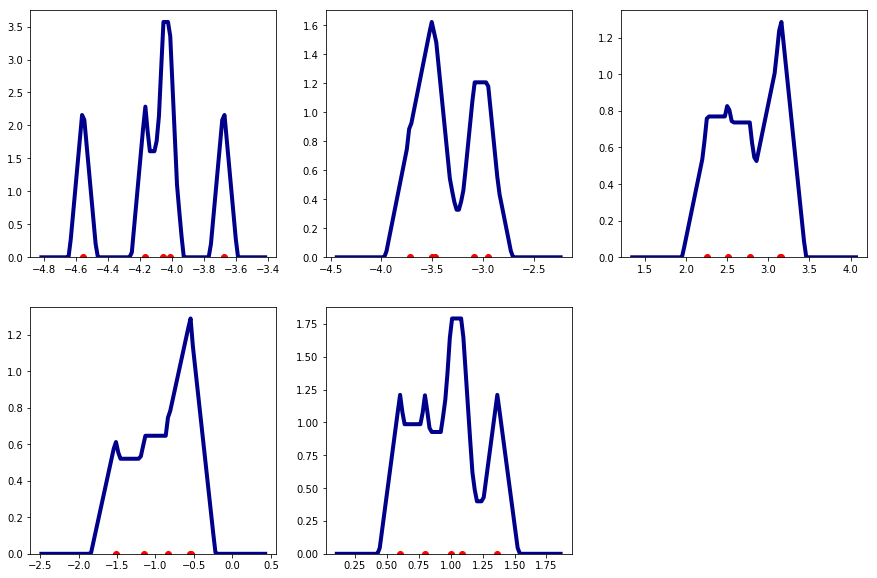

In [37]:
plot_projections(dm, use_real=False)

In [50]:
torch.load('Experiments/Checkpoints/e0-199_model_4.pth')['lt.theta_0'].shape

torch.Size([14546, 1])

#### 1. particles - 1 + no latent

In [ ]:
### MAP estimate for MNIST classification task
net_1 = nn.Sequential(SteinLinear(28 * 28, 18, 1, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(18, 14, 1, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(14, 10, 1, use_var_prior=False)
                     ).to(device=device)
data_distr_1 = ClassificationDistribution(1)
dm_1 = DistributionMover(task='net_class', n_particles=1, use_latent=False, net=net_1, data_distribution=data_distr_1)
lr_str_1 = LRStrategy(step_size=0.03, factor=0.97, n_epochs=1, patience=80)

In [ ]:
own_name_1 = 'model_1'
version_1 = 19
checkpoint_file_name_1 = './Experiments/Checkpoints/' + 'e{0}_' + own_name_1 + '.pth'
plots_file_name_1 = './Experiments/Plots/' + own_name_1 + '.png'
log_file_name_1 = './Experiments/Logs/' + own_name_1 + '.txt'
if os.path.exists(checkpoint_file_name_1.format(version_1)):
    dm_1.load_state_dict(torch.load(checkpoint_file_name_1.format(version_1)))
    lr_str_1.step_size = dm_1.step_size
    lr_str_1.iter = dm_1.epoch + 1

In [ ]:
train(dm=dm_1,
      dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
      lr_str=lr_str_1, start_epoch=lr_str_1.iter, end_epoch=26,
      checkpoint_file_name=checkpoint_file_name_1, plots_file_name=plots_file_name_1, log_file_name=log_file_name_1,
      n_warmup_epochs=5
     )

In [ ]:
# X, y = next(iter(dataloader_m_train))
# X = X.double().to(device=device).view(X.shape[0], -1)
# y = y.to(device=device)
# burn_in_coeff = max(1. - (1. - 1.) / 20. * 1, 1.)
# %lprun -f DistributionMover.update_latent_net dm_1.update_latent_net(h_type=0, kernel_type='rbf', p=None, X_batch=X, y_batch=y, train_size=len(dataloader_m_train) * dataloader_m_train.batch_size, step_size=lr_str_1.step_size, move_theta_0=True, burn_in=True, burn_in_coeff=burn_in_coeff, epoch=1)

#### 2. particles - 5 + latent - 700

In [ ]:
net_2 = nn.Sequential(SteinLinear(28 * 28, 18, 5, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(18, 14, 5, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(14, 10, 5, use_var_prior=False)
                     ).to(device=device)
data_distr_2 = ClassificationDistribution(5)
dm_2 = DistributionMover(task='net_class',
                         n_particles=5,
                         n_hidden_dims=700,
                         use_latent=True,
                         net=net_2,
                         data_distribution=data_distr_2
                        )
lr_str_2 = LRStrategy(step_size=0.03, factor=0.97, n_epochs=1, patience=80)

In [ ]:
own_name_2 = 'model_2'
version_2 = 0
checkpoint_file_name_2 = './Experiments/Checkpoints/' + 'e{0}_' + own_name_2 + '.pth'
plots_file_name_2 = './Experiments/Plots/' + own_name_2 + '.png'
log_file_name_2 = './Experiments/Logs/' + own_name_2 + '.txt'
if os.path.exists(checkpoint_file_name_2.format(version_2)):
    dm_2.load_state_dict(torch.load(checkpoint_file_name_2.format(version_2)))
    lr_str_2.step_size = dm_2.step_size
    lr_str_2.iter = dm_2.epoch + 1

In [ ]:
train(dm=dm_2,
      dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
      lr_str=lr_str_2, start_epoch=lr_str_2.iter, end_epoch=lr_str_2.iter + 100, n_epochs_save=20,
      checkpoint_file_name=checkpoint_file_name_2, plots_file_name=plots_file_name_2, log_file_name=log_file_name_2,
      n_warmup_epochs=16
     )

In [ ]:
# X, y = next(iter(dataloader_m_train))
# X = X.double().to(device=device).view(X.shape[0], -1)
# y = y.to(device=device)
# burn_in_coeff = max(1. - (1. - 1.) / 20. * 1, 1.)
# %lprun -f DistributionMover.update_latent_net dm_2.update_latent_net(h_type=0, kernel_type='rbf', p=None, X_batch=X, y_batch=y, train_size=len(dataloader_m_train) * dataloader_m_train.batch_size, step_size=lr_str_2.step_size, move_theta_0=True, burn_in=True, burn_in_coeff=burn_in_coeff, epoch=1)

#### 3. particles - 5 + no latent

In [ ]:
net_3 = nn.Sequential(SteinLinear(28 * 28, 18, 5, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(18, 14, 5, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(14, 10, 5, use_var_prior=False)
                     ).to(device=device)
data_distr_3 = ClassificationDistribution(5)
dm_3 = DistributionMover(task='net_class',
                       n_particles=5,
                       use_latent=False,
                       net=net_3,
                       data_distribution=data_distr_3
                      )
lr_str_3 = LRStrategy(step_size=0.03, factor=0.97, n_epochs=1, patience=80)

In [ ]:
own_name_3 = 'model_3'
version_3 = 0
checkpoint_file_name_3 = './Experiments/Checkpoints/' + 'e{0}_' + own_name_3 + '.pth'
plots_file_name_3 = './Experiments/Plots/' + own_name_3 + '.png'
log_file_name_3 = './Experiments/Logs/' + own_name_3 + '.txt'
if os.path.exists(checkpoint_file_name_3.format(version_3)):
    dm_3.load_state_dict(torch.load(checkpoint_file_name_3.format(version_3)))
    lr_str_3.step_size = dm_3.step_size
    lr_str_3.iter = dm_3.epoch + 1

In [ ]:
train(dm=dm_3,
      dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
      lr_str=lr_str_3, start_epoch=lr_str_3.iter, end_epoch=lr_str_3.iter + 100, n_epochs_save=20,
      checkpoint_file_name=checkpoint_file_name_3, plots_file_name=plots_file_name_3, log_file_name=log_file_name_3,
      n_warmup_epochs=16
     )

In [ ]:
# X, y = next(iter(dataloader_m_train))
# X = X.double().to(device=device).view(X.shape[0], -1)
# y = y.to(device=device)
# burn_in_coeff = max(1. - (1. - 1.) / 20. * 1, 1.)
# %lprun -f DistributionMover.update_latent_net dm_3.update_latent_net(h_type=0, kernel_type='rbf', p=None, X_batch=X, y_batch=y, train_size=len(dataloader_m_train) * dataloader_m_train.batch_size, step_size=lr_str_3.step_size, move_theta_0=True, burn_in=True, burn_in_coeff=burn_in_coeff, epoch=1)

#### 4. particles - 20 + latent - 700

In [ ]:
net_4 = nn.Sequential(SteinLinear(28 * 28, 18, 20, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(18, 14, 20, use_var_prior=False),
                      nn.Tanh(),
                      SteinLinear(14, 10, 20, use_var_prior=False)
                     ).to(device=device)
data_distr_4 = ClassificationDistribution(20)
dm_4 = DistributionMover(task='net_class',
                         n_particles=20,
                         n_hidden_dims=700,
                         use_latent=True,
                         net=net_4,
                         data_distribution=data_distr_4
                        )
lr_str_4 = LRStrategy(step_size=0.03, factor=0.97, n_epochs=1, patience=80)

In [ ]:
own_name_4 = 'model_4'
version_4 = 0
checkpoint_file_name_4 = './Experiments/Checkpoints/' + 'e{0}_' + own_name_4 + '.pth'
plots_file_name_4 = './Experiments/Plots/' + own_name_4 + '.png'
log_file_name_4 = './Experiments/Logs/' + own_name_4 + '.txt'
if os.path.exists(checkpoint_file_name_4.format(version_4)):
    dm_4.load_state_dict(torch.load(checkpoint_file_name_4.format(version_4)))
    lr_str_4.step_size = dm_4.step_size
    lr_str_4.iter = dm_4.epoch + 1

In [ ]:
train(dm=dm_4,
      dataloader_train=dataloader_m_train, dataloader_test=dataloader_m_test,
      lr_str=lr_str_4, start_epoch=lr_str_4.iter, end_epoch=lr_str_4.iter + 100, n_epochs_save=20,
      checkpoint_file_name=checkpoint_file_name_4, plots_file_name=plots_file_name_4, log_file_name=log_file_name_4,
      n_warmup_epochs=16
     )

### MNIST with FC neural net

In [ ]:
net_nn = nn.Sequential(
    nn.Linear(28 * 28, 200),
    nn.ReLU(),
    nn.Linear(200, 200), 
    nn.ReLU(),
    nn.Linear(200, 10)
).double()
optim_nn = torch.optim.Adam(net_nn.parameters(), 1e-2)

In [ ]:
try:
    for _, (X, y) in enumerate(dataloader_m_train):
        X = X.double().view(X.shape[0], -1)
        
        optim_nn.zero_grad()
        train_loss = nn.CrossEntropyLoss()(net_nn(X), y)
        train_loss.backward()
        optim_nn.step()
   
        train_loss = 0. 
        train_acc = 0.
        for __ in range(30):
            X_train, y_train = next(iter(dataloader_m_train))
            X_train = X_train.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(net_nn(X_train)), dim=1)
            train_loss += nn.CrossEntropyLoss()(net_nn(X_train), y_train)
            train_acc += torch.sum(y_pred == y_train).float()
        train_loss /= 30.
        train_acc /= (30. * dataloader_m_train.batch_size)
        
        test_loss = 0.
        test_acc = 0.
        for __ in range(30):
            X_test, y_test = next(iter(dataloader_m_test))
            X_test = X_test.double().view(X.shape[0], -1)

            y_pred = torch.argmax(nn.Softmax()(net_nn(X_test)), dim=1)
            test_loss += nn.CrossEntropyLoss()(net_nn(X_test), y_test)
            test_acc += torch.sum(y_pred == y_test).float()
        test_loss /= 30.
        test_acc /= (30. * dataloader_m_test.batch_size)
        
        if _ % 1 == 0:
            sys.stdout.write('\rEpoch {0}... Empirical Loss(Train/Test): {1:.3f}/{2:.3f}\t Accuracy(Train/Test): {3:.3f}/{4:.3f}\t Kernel factor: {5:.3f}'.format(
                            _, train_loss, test_loss, train_acc, test_acc, dm.h))
            
except KeyboardInterrupt:
    pass

In [ ]:
X_test, y_test = next(iter(dataloader_m_test))
X_test = X_test.double().view(X.shape[0], -1)
y_pred = net_nn(X_test)
torch.argmax(nn.Softmax()(y_pred), dim=1)[2], y_test[2]

## Distribution approximation

In [ ]:
marginal_density = lambda x : (0.3 * normal_density(mu=-2., std=1., n=1)(x) + 0.7 * normal_density(mu=2., std=1., n=1)(x))
#marginal_density = lambda x : (normal_density(mu=0., std=2., n=1)(x))

pdf = []
for _ in np.linspace(-10, 10, 1000): 
    _ = torch.tensor(_, dtype=t_type, device=device)
    pdf.append(marginal_density(_))
    
from pynverse import inversefunc
from scipy.interpolate import interp1d
from scipy.integrate import quad
cum_density = interp1d(np.linspace(-20, 20, 250), [quad(marginal_density, -20, x)[0] for x in np.linspace(-20, 20, 250)])
inv_cum_density = inversefunc(cum_density)
real_samples = [inv_cum_density(np.random.random()) for x in range(1000)]

In [ ]:
mean = quad(lambda x : marginal_density(x) * x, -20, 20)[0]
var = quad(lambda x : marginal_density(x) * (x - mean) ** 2, -20, 20)[0]

In [ ]:
mean, var

In [ ]:
plt.plot(np.linspace(-10, 10, 1000), pdf)
plt.plot(real_samples, np.zeros_like(real_samples))
sns.kdeplot(real_samples, kernel='tri', color='darkblue', linewidth=4)

In [ ]:
dm = DistributionMover(task='app', n_particles=100, n_dims=20, n_hidden_dims=5, use_latent=False)

In [ ]:
# plot_projections(dm, use_real=True, N_plots_max=1, pdf=pdf)
# plot_projections(dm, use_real=False, N_plots_max=1, pdf=pdf)

In [ ]:
# %%time

for _ in range(3000): 
    try:
        dm.update_latent(h_type=0, kernel_type='rbf', p=-1)

        if _ % 100 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

            plot_projections(dm, use_real=True, kernel='tri', pdf=pdf)
            plot_projections(dm, use_real=False, kernel='tri', pdf=pdf)

            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
(torch.mean(dm.lt.transform(dm.particles, n_particles_second=True)),
 torch.mean(torch.std(dm.lt.transform(dm.particles, n_particles_second=True), dim=1) ** 2))

## Conditional Distributions

In [ ]:
dm = DistributionMover(task='app', n_particles=100, n_dims=2, n_hidden_dims=1, use_latent=True)

In [ ]:
plot_condition_distribution(dm, 100000)

In [ ]:
# %%time

for _ in range(200): 
    try:
        dm.update_latent(h_type=0, kernel_type='rbf', p=-1)

        if _ % 100 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))
            
            #plot_projections(dm, use_real=True, pdf=pdf)
            plot_condition_distribution(dm, 100000)
            
            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# Make data.
X = np.arange(-5, 5, 0.025)
Y = np.arange(-5, 5, 0.025)
XX, YY = np.meshgrid(X, Y)
XY = torch.stack([torch.tensor(XX, dtype=t_type), torch.tensor(YY, dtype=t_type)], dim=2)
Z = torch.zeros([XY.shape[0], XY.shape[1]])

Z = dm.real_target_density(XY.permute(2, 0, 1).view(2, -1)).view(Z.shape)
Z = Z.cpu().data.numpy()

# Plot the surface.
plt.contour(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Plot conditioning line
XXX, YYY = dm.lt.transform(torch.tensor(X, dtype=t_type, device=device).view(1, -1), n_particles_second=True).data.cpu().numpy()
plt.plot(XXX, YYY, 'r', label='Linear manifold', )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Density contour lines")

plt.show()

# Compare implementations of Stein Gradients

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

class SVGD():

    def __init__(self):
        pass
    
    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)  
            h = h / np.log(theta.shape[0]+1)

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = 2. * dxkxy / (h)
        return (Kxy, dxkxy)
    
 
    def update(self, x0, lnprob, n_iter = 1000, stepsize = 1e-3, bandwidth = -1, alpha = 0.9, debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')
        
        theta = np.copy(x0) 
        
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print( 'iter ' + str(iter+1) )
            
            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy = self.svgd_kernel(theta, h = bandwidth)  
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]  
            
            # adagrad 
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad 
            
        return theta

In [ ]:
dm_ex = DistributionMover(n_particles=100, n_dims=20, n_hidden_dims=20, use_latent=False)

In [ ]:
dm_svgd = SVGD()

In [ ]:
def lnprob(particles):
    grad_log_term = torch.zeros([particles.shape[0], particles.shape[1]], dtype=t_type, device=device)
        
    for idx in range(100):
        particle = torch.tensor(particles[idx:idx+1], dtype=t_type, device=device, requires_grad=True)
        log_term = torch.log(dm_ex.target_density(particle.t()))
        grad_log_term[idx] = torch.autograd.grad(log_term, particle,
                                                     only_inputs=True, retain_graph=False, 
                                                     create_graph=False, allow_unused=False)[0]
    return grad_log_term

In [ ]:
result = dm_ex.particles.data.clone().detach().t()

In [ ]:
## Compare kernel implementation

ker, grad_ker = dm_ex.calc_kernel_term_latent(10.)
print(dm_ex.h)
grad_ker_sum = torch.sum(grad_ker, dim=1)

ker_l, grad_ker_sum_l = dm_svgd.svgd_kernel(result, h=10.)

print((ker - torch.tensor(ker_l, dtype=t_type, device=device)).norm())
print((grad_ker_sum - torch.tensor(grad_ker_sum_l, dtype=t_type, device=device).t()).norm())

In [ ]:
## Compare log_term implementation
(lnprob(result) - dm_ex.calc_log_term_latent().t()).norm()

In [ ]:
for _ in range(201): 
    try:
        result = dm_svgd.update(result, lnprob, stepsize=1e-2, bandwidth=-1, n_iter=20)
        result = torch.tensor(result, dtype=t_type, device=device)

        if _ % 1 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm.h))

            plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
            plt.plot(result.data.cpu().numpy(), torch.zeros_like(result).data.cpu().numpy(), 'ro')
            sns.kdeplot(result.data.cpu().numpy()[:,0], 
                        kernel='tri', color='darkblue', linewidth=4)

            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
%%time

for _ in range(2000): 
    try:
        dm_ex.update_latent(h_type=0)

        if _ % 30 == 0:
            clear_output()
            sys.stdout.write('\rEpoch {0}...\nKernel factor {1}'.format(_, dm_ex.h))
            
            plt.plot(np.linspace(-10, 10, 1000, dtype=np.float64), pdf)
            plt.plot(dm_ex.particles.t().data.cpu().numpy(), torch.zeros_like(dm_ex.particles.t()).data.cpu().numpy(), 'ro')
            sns.kdeplot(dm_ex.particles.t().data.cpu().numpy()[:,0], 
                        kernel='tri', color='darkblue', linewidth=4)

            plt.pause(1e-300)

    except KeyboardInterrupt:
        break

In [ ]:
(result - dm_ex.particles.t()).norm()

# Logistic Regression from original paper

In [ ]:
sys.path.insert(0, "Stein-Variational-Gradient-Descent/python/")
import numpy as np
import scipy.io
from sklearn.cross_validation import train_test_split
import numpy.matlib as nm
from svgd import SVGD

r"""
    Example of Bayesian Logistic Regression (the same setting as Gershman et al. 2012):
    The observed data D = {X, y} consist of N binary class labels, 
    y_t \in {-1,+1}, and d covariates for each datapoint, X_t \in R^d.
    The hidden variables \theta = {w, \alpha} consist of d regression coefficients w_k \in R,
    and a precision parameter \alpha \in R_+. We assume the following model:
        p(\alpha) = Gamma(\alpha; a, b)
        p(w_k | a) = N(w_k; 0, \alpha^-1)
        p(y_t = 1| x_t, w) = 1 / (1+exp(-w^T x_t))
"""
class BayesianLR:
    def __init__(self, X, Y, batchsize=100, a0=1, b0=0.01):
        self.X, self.Y = X, Y
        # TODO. Y in \in{+1, -1}
        self.batchsize = min(batchsize, X.shape[0])
        self.a0, self.b0 = a0, b0
        
        self.N = X.shape[0]
        self.permutation = np.random.permutation(self.N)
        self.iter = 0
    
        
    def dlnprob(self, theta):
        
        if self.batchsize > 0:
            batch = [ i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize) ]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])
            
        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]
        
        w = theta[:, :-1]  # logistic weights
        alpha = np.exp(theta[:, -1])  # the last column is logalpha
        d = w.shape[1]
        
        wt = np.multiply((alpha / 2), np.sum(w ** 2, axis=1))
        
        coff = np.matmul(Xs, w.T)
        y_hat = 1.0 / (1.0 + np.exp(-1 * coff))
        
        dw_data = np.matmul(((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T, Xs)  # Y \in {-1,1}
        dw_prior = -np.multiply(nm.repmat(np.vstack(alpha), 1, d) , w)
        dw = dw_data * 1.0 * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale
        
        dalpha = d / 2.0 - wt + (self.a0 - 1) - self.b0 * alpha + 1  # the last term is the jacobian term
        
        return np.hstack([dw, np.vstack(dalpha)])  # % first order derivative 
    
    def evaluation(self, theta, X_test, y_test):
        theta = theta[:, :-1]
        M, n_test = theta.shape[0], len(y_test)

        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.multiply(y_test, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n_test, 1), X_test), axis=1))
            prob[:, t] = np.divide(np.ones(n_test), (1 + np.exp(coff)))
        
        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        llh = np.mean(np.log(prob))
        return [acc, llh]

In [ ]:
N = X_test.shape[0] + X_train.shape[0]
X_input = np.hstack([X, np.ones([N, 1])])
y_input = y
d = X_input.shape[1]
D = d + 1
    
# split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)
    
a0, b0 = 1, 0.01 #hyper-parameters
model = BayesianLR(X_train, y_train, 100, a0, b0) # batchsize = 100
    
# initialization
M = 100  # number of particles
theta0 = np.zeros([M, D]);
alpha0 = np.random.gamma(a0, b0, M); 
for i in range(M):
    theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])])
    
theta = SVGD().update(x0=theta0, lnprob=model.dlnprob, bandwidth=-1, n_iter=6000, stepsize=0.05, alpha=0.9, debug=True)
    
print('[accuracy, log-likelihood]')
print(model.evaluation(theta, X_test, y_test))

# Metropolis–Hastings algorithm 

In [ ]:
class MHAlgorithm():
    def __init__(self, n_dims): 
        self.n_dims = n_dims
        
        self.target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs) +
                                                           0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True).unnormed_density(x, *args, **kwargs))

        self.real_target_density = lambda x, *args, **kwargs : (0.3 * normal_density(self.n_dims, -2., 1., n_particles_second=True)(x, *args, **kwargs) +
                                                                0.7 * normal_density(self.n_dims, 2., 1., n_particles_second=True)(x, *args, **kwargs))
        
#         self.target_density = lambda x : (normal_density(self.n_dims, 0., 2., n_particles_second=True).unnormed_density(x))

#         self.real_target_density = lambda x : (normal_density(self.n_dims, 0., 2., n_particles_second=True)(x))

    
        self.particles = torch.zeros(
            [self.n_dims, 1],
            dtype=t_type,
            requires_grad=False,
            device=device).uniform_(-2., -1.)
        
        self.one = torch.tensor(1., dtype=t_type, device=device)
        
    def generate_next(self):
        previous = self.particles[:, -1].unsqueeze(1)
#         self.additional_distribution = normal_density(self.n_dims, previous, 1, n_particles_second=True)
#         candidate = self.additional_distribution.get_sample()
        
#         alpha = (self.target_density(candidate) * self.additional_distribution.unnormed_density(previous) / 
#                 (self.target_density(previous) * self.additional_distribution.unnormed_density(candidate)))
        candidate = previous + torch.zeros([self.n_dims, 1], device=device, dtype=t_type).uniform_(-1., 1.)
        alpha = self.target_density(candidate) / self.target_density(previous)
        
#         print(self.target_density(candidate)[0].data.numpy(), self.additional_distribution.unnormed_density(previous)[0].data.numpy(),
#               self.target_density(previous)[0].data.numpy(), self.additional_distribution.unnormed_density(candidate)[0].data.numpy())
        
        if alpha > self.one:
            self.particles = torch.cat([self.particles, candidate], dim=1)
        else:
            random = torch.bernoulli(alpha)
            if random:
                self.particles = torch.cat([self.particles, candidate], dim=1)                
            else:
                self.particles = torch.cat([self.particles, previous], dim=1)

In [ ]:
mh = MHAlgorithm(3)

In [ ]:
for _ in range(10000):
    mh.generate_next()

In [ ]:
sns.kdeplot(mh.particles.t().data.cpu().numpy()[:,1], 
            kernel='tri', color='darkblue', linewidth=4)

In [ ]:
hist_plot(mh.particles.t().data.cpu().numpy()[:,1])

In [ ]:
import numpy as np
import math
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import time

mu,sig,N = 0,1,1000000
pts = []

def q(x):
#     return (1/(math.sqrt(2*math.pi*sig**2)))*(math.e**(-((x-mu)**2)/(2*sig**2)))
#     return normal_density(1, 0., 2., n_particles_second=True).unnormed_density(x)
    return (0.3 * normal_density(1, -2., 1., n_particles_second=True).unnormed_density(x) +
            0.7 * normal_density(1, 2., 1., n_particles_second=True).unnormed_density(x))

def metropolis(N):
    r = np.zeros(1)
    p = q(r[0])
    pts = []
    
    for i in range(N):
        rn = r + np.random.uniform(-1,1)
        pn = q(rn[0])
        if pn >= p:
            p = pn
            r = rn
        else:
            u = np.random.rand()
            if u < pn/p:
                p = pn
                r = rn
        pts.append(r)
    
    pts = np.array(pts)
    return pts
    
def hist_plot(array):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,)
    ax.hist(array, bins=1000)    
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')

In [ ]:
hist_plot(metropolis(100000))

In [ ]:
gg =  lambda : (normal_density(1, -60., 20., n_particles_second=True).get_sample())

In [ ]:
hist_plot([gg()[0,0] for _ in range(1000000)])